In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
from PIL import Image
from tqdm import tqdm_notebook as tqdm
import random
from matplotlib import pyplot as plt

/home/ha/anaconda3/envs/self/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/ha/anaconda3/envs/self/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Train / Val 한번에 transform하기

In [3]:
class ImageTransform():    
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
        
    def __call__(self, img, phase):
        return self.data_transform[phase](img)

In [4]:
cat_directory = r'./data/cd/Cat/'
dog_directory = r'./data/cd/Dog/'

cat_images_filepaths = sorted([os.path.join(cat_directory, f) for f in os.listdir(cat_directory)])   
dog_images_filepaths = sorted([os.path.join(dog_directory, f) for f in os.listdir(dog_directory)])
images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]    
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]    

random.seed(42)    
random.shuffle(correct_images_filepaths)
train_images_filepaths = correct_images_filepaths[:400]    
val_images_filepaths = correct_images_filepaths[400:-10]  
test_images_filepaths = correct_images_filepaths[-10:]    
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

400 92 10


In [5]:
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

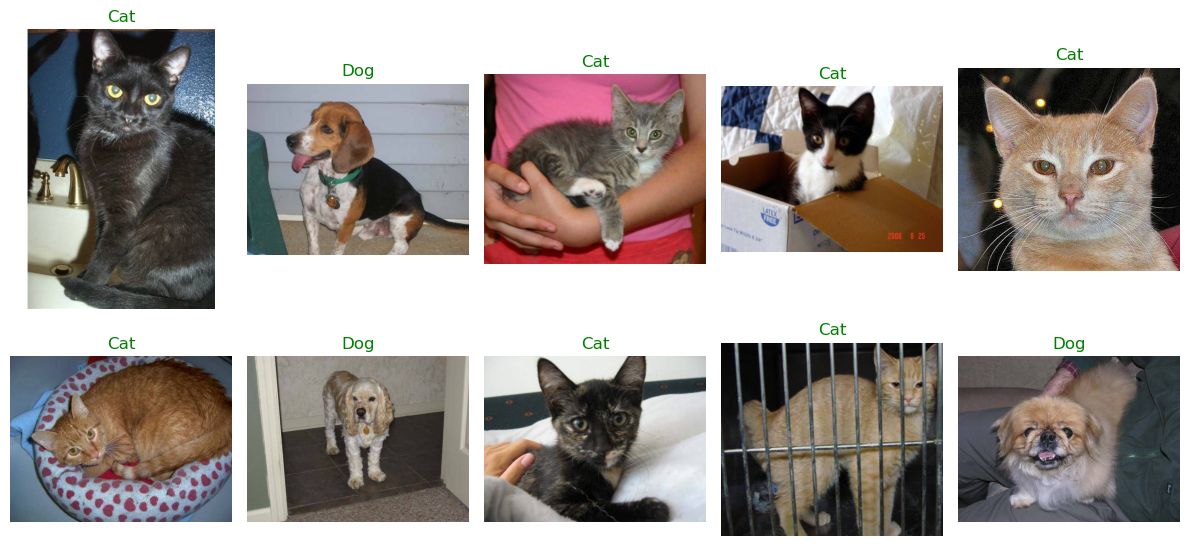

In [6]:
display_image_grid(test_images_filepaths)

In [7]:
# torch.utils.data.Dataset is an abstract class representing a dataset. Your custom dataset should inherit Dataset and override the following methods: __len__ & getitem__
class DogvCatDataset(Dataset):
    def __init__(self, file_list, transform=None, phase ='train'):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img, self.phase)
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0
        return img_transformed, label

In [8]:
size = 224
mean = (0.485,0.456,0.406)
std = (0.229,0.224,0.225)
batch_size = 32

In [9]:
train_dataset = DogvCatDataset(train_images_filepaths,transform = ImageTransform(size,mean,std), phase = 'train')
val_dataset = DogvCatDataset(val_images_filepaths,transform = ImageTransform(size,mean,std), phase='val')


In [10]:
index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 224, 224])
0


In [11]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {'train':train_dataloader, 'val':val_dataloader}

batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([32, 3, 224, 224])
tensor([0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
        1, 1, 0, 0, 0, 1, 0, 0])


In [12]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet,self).__init__()
        self.cnn1 = nn.Conv2d(3,16,5,1,0) #in,out,kernel,stride,padding
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(2)
        
        self.cnn2 = nn.Conv2d(16,32,5,1,0)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(32*53*53,512)
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(512,2)
        self.output = nn.Softmax(dim=1)
    
    def forward(self,x):
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = out.view(out.size(0),-1) # (batch_size, 나머지:32*53*53)
        out = self.fc1(out)
        out = self.relu5(out)
        out = self.fc2(out)
        out = self.output(out)
        return out


In [13]:
from torchsummary import summary
model = LeNet()
model.to(device)
summary(model,input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 220, 220]           1,216
              ReLU-2         [-1, 16, 220, 220]               0
         MaxPool2d-3         [-1, 16, 110, 110]               0
            Conv2d-4         [-1, 32, 106, 106]          12,832
              ReLU-5         [-1, 32, 106, 106]               0
         MaxPool2d-6           [-1, 32, 53, 53]               0
            Linear-7                  [-1, 512]      46,023,168
              ReLU-8                  [-1, 512]               0
            Linear-9                    [-1, 2]           1,026
          Softmax-10                    [-1, 2]               0
Total params: 46,038,242
Trainable params: 46,038,242
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 19.47
Params size (MB): 175.62
Es

In [14]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion =nn.CrossEntropyLoss()

In [15]:
model = model.to(device)
criterion = criterion.to(device)

In [16]:
import time

In [17]:
def train_model(model, dataloader_dict, criterion, optimizer, num_epoch):
    since = time.time()
    best_acc = 0.0

    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch+1,num_epoch))
        print('-'*10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            epoch_loss = 0.0
            epoch_corrects = 0

            for inputs, labels in tqdm(dataloader_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _,preds = torch.max(outputs,1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds ==labels.data)
            
            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)

            print('{} Loss: {:.4}f Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
    time_eplased = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_eplased//60, time_eplased%60))
    print('Best val Acc: {:.4f}'.format(best_acc))
    return model

In [18]:
num_epoch=10
model = train_model(model, dataloader_dict,criterion,optimizer,num_epoch)

Epoch 1/10
----------


/tmp/ipykernel_15364/2338421367.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs, labels in tqdm(dataloader_dict[phase]):


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6937f Acc: 0.4950


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6912f Acc: 0.4891
Epoch 2/10
----------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6907f Acc: 0.5425


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6957f Acc: 0.4783
Epoch 3/10
----------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6831f Acc: 0.6000


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.698f Acc: 0.4674
Epoch 4/10
----------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6801f Acc: 0.6000


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6965f Acc: 0.5217
Epoch 5/10
----------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6746f Acc: 0.6100


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.694f Acc: 0.5326
Epoch 6/10
----------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6736f Acc: 0.6225


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6945f Acc: 0.5652
Epoch 7/10
----------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6708f Acc: 0.5900


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6912f Acc: 0.5326
Epoch 8/10
----------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.664f Acc: 0.6125


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.691f Acc: 0.5109
Epoch 9/10
----------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6563f Acc: 0.6100


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6838f Acc: 0.5870
Epoch 10/10
----------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6548f Acc: 0.6250


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6931f Acc: 0.5326
Training complete in 0m 22s
Best val Acc: 0.5870


In [19]:
import pandas as pd
id_list = []
pred_list = []
_id = 0

with torch.no_grad():
    for test_path in tqdm(test_images_filepaths):
        img = Image.open(test_path)
        _id = test_path.split('/')[-1].split('.')[1]
        transform = ImageTransform(size,mean,std)
        img = transform(img,phase='val')
        img = img.unsqueeze(0)
        img = img.to(device)

        model.eval()
        outputs = model(img) # torch.Size([1, 2]) # case 한개 output 2개
        preds = F.softmax(outputs,dim=1)[:,1].tolist() # 1번째 index를 가져온다 개의 여부
        id_list.append(_id)
        pred_list.append(preds[0])
res = pd.DataFrame({
    'id':id_list,
    'label': pred_list
})
res.sort_values(by='id', inplace=True)
res.reset_index(drop=True, inplace=True)

res.to_csv('./LeNet.csv',index=False)

/tmp/ipykernel_15364/4213987462.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for test_path in tqdm(test_images_filepaths):


  0%|          | 0/10 [00:00<?, ?it/s]

In [20]:
class_ = classes = {0:'cat',1:'dog'}
def display_image_grid(images_filepaths,predicted_labels=(),cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows,ncols=cols,figsize=(12,6))
    for i, images_filepath in enumerate(images_filepaths):
        image = cv2.imread(images_filepath)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        a = random.choice(res['id'].values)
        label = res.loc[res['id']==a, 'label'].values[0]
        if label > 0.5:
            label=1
        else:
            label=0
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

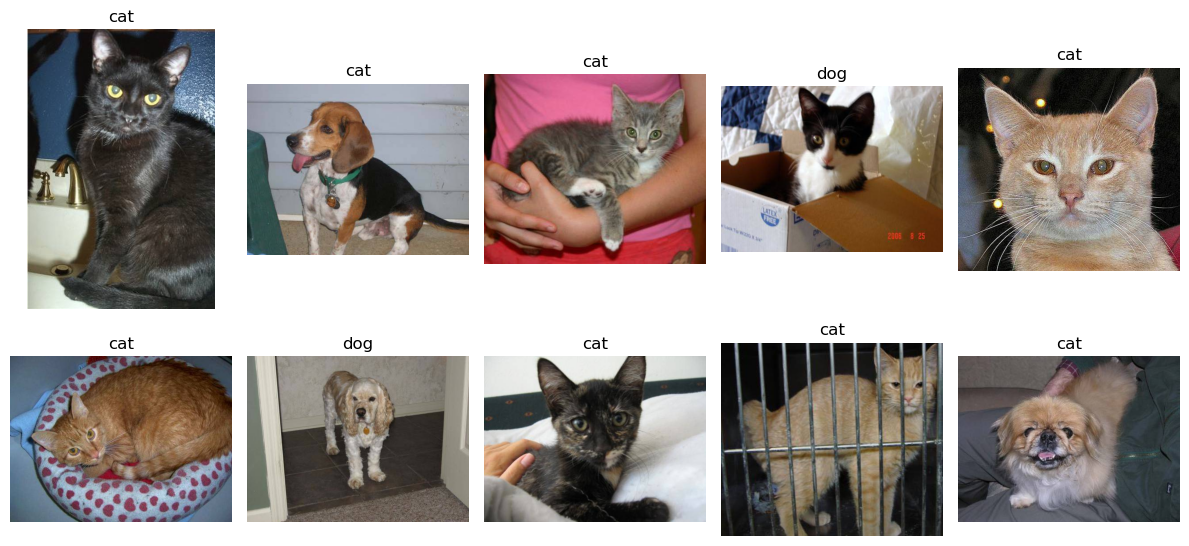

In [21]:
display_image_grid(test_images_filepaths)